### Kelompok 1 Offering A
1. ALYYUSYAWAL ARJUNA WIDARDI (220535610847)
2. ANISSA ALIFIA PUTRI (220535600012)
3. 	DAVID SATRIA ALAMSYAH (220535610311)
4. DITA ANGGRAINI PUSPITASARI (220535609256)



### Import the libraries

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
import heapq
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!python --version

Python 3.10.12


### Prepocessing Data

In [ ]:
# Load the dataset
df = pd.read_csv('mahabharata_story.csv')

# Display the first 10 rows
df.head(10)

,paragraphs,reference_summary
0,Mênggah ing wigatosipun pakêmpalan dintên puni...,Pakêmpalan dintên punika nyuraos Sêrat Mahabar...
1,Tiyang kêdah sumêrap kadospundi anggènipun mar...,Tiyang kêdah nyamêkta cipta lan wosing patrap ...
2,Sasampunipun lajêng dipun pêndhêta saparwa-sap...,"Sasampunipun pêndhêta, têrangipun lêlampahan l..."
3,Ing dunya kathah tiyang ingkang botên pitados ...,Jêjaka Hindhu kêdah ngrêtos sêrat suksci supad...
4,"Manawi tiningalan saking kawruh kasusastran, s...","Mahabarata gadhah ajên luhur ing kawruh, ngluw..."
5,Saèstunipun jêngandika sampun sami maos anggi...,"Mahabarata minangka kêkidungan luhur sangêt, n..."
6,"Punika pusakanipun băngsa Arya, amila prayogi ...",Pusaka Arya punika ngemot piwulang kasusilan l...
7,"Bab piwulang kasusilan, punika pikajêngipun a...",Piwulang kasusilan ngajari lampah sae lan awon...
8,"Sêrat Mahabarata, punika wiyaripun kados cakra...","Mahabarata ngajari wêwatakan, darmanipun warga..."
9,"Makatên patrap pamulangipun dhatêng tiyang, mu...",Guru kêdah mulang kanthi têtuladan kang têrang...


In [ ]:
# Function to clean text by removing special characters, numbers, and unwanted symbols
def cleansing(text):
    text = text.lower()  # Convert text to lowercase
    text = re.sub('\[.*?\]', '', text)  # Remove text within square brackets
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)  # Remove punctuation
    text = re.sub('\w*\d\w*', '', text)  # Remove words containing numbers
    text = re.sub('[‘’“”…]', '', text)  # Remove special quotes and ellipses
    text = re.sub('\n', '', text)  # Remove newline characters
    return text

In [ ]:
# Function to remove stopwords from the text
def remove_stopwords(text):
    # Load stopwords from a file
    with open('javanese_stopwords.txt', 'r', encoding='utf-8') as file:
        stopwords = set(file.read().splitlines())  # Read and split stopwords into a set

    # Filter out stopwords from the text
    words = text.split()  # Split the text into words
    filtered_words = [word for word in words if word.lower() not in stopwords]  # Remove stopwords

    return ' '.join(filtered_words)  # Join the filtered words back into a single string


In [ ]:
# Function to perform lemmatization on text
def lemmatize_text(text):
    # Load dictionary of basic words
    with open('javanese_dictionary.txt', 'r', encoding='utf-8') as file:
        basic_word = set(file.read().splitlines())  # Read dictionary into a set of basic words

    # Replace words with their basic forms if they exist in the dictionary
    return ' '.join([word.lower() if word.lower() in basic_word else word for word in text.split()])



In [ ]:
# Function to preprocess text data
def preprocessing(data, stopwords=False, lemmatization=False):
    data = data.apply(cleansing)  # Apply text cleansing to all data
    if stopwords:  # Remove stopwords if the parameter is True
        data = data.apply(lambda x: remove_stopwords(x))
    if lemmatization:  # Perform lemmatization if the parameter is True
        data = data.apply(lambda x: lemmatize_text(x))
    return data  # Return the processed data



In [ ]:
# Preprocess the 'paragraphs' column with stopwords removal and lemmatization
df['paragraphs'] = preprocessing(df['paragraphs'], stopwords=True, lemmatization=True)

# Preprocess the 'reference_summary' column with lemmatization only (no stopwords removal)
df['reference_summary'] = preprocessing(df['reference_summary'], stopwords=False, lemmatization=True)


In [ ]:
df.head(10)

,paragraphs,reference_summary
0,mênggah wigatosipun pakêmpalan dintên punika b...,pakêmpalan dintên punika nyuraos sêrat mahabar...
1,tiyang kêdah sumêrap kadospundi anggènipun mar...,tiyang kêdah nyamêkta cipta lan wosing patrap ...
2,sasampunipun lajêng dipun pêndhêta saparwasapa...,sasampunipun pêndhêta têrangipun lêlampahan la...
3,dunya kathah tiyang ingkang botên pitados mana...,jêjaka hindhu kêdah ngrêtos sêrat suksci supad...
4,manawi tiningalan saking kawruh kasusastran sê...,mahabarata gadhah ajên luhur ing kawruh ngluwi...
5,saèstunipun jêngandika sampun sami maos anggit...,mahabarata minangka kêkidungan luhur sangêt ng...
6,punika pusakanipun băngsa arya amila prayogi s...,pusaka arya punika ngemot piwulang kasusilan l...
7,bab piwulang kasusilan punika pikajêngipun ang...,piwulang kasusilan ngajari lampah sae lan awon...
8,sêrat mahabarata punika wiyaripun kados cakraw...,mahabarata ngajari wêwatakan darmanipun warga ...
9,makatên patrap pamulangipun dhatêng tiyang mur...,guru kêdah mulang kanthi têtuladan kang têrang...


In [ ]:
# Add special tokens (_START_ and _END_) to the 'reference_summary' column
df['reference_summary'] = df['reference_summary'].apply(lambda x: f"_START_ {x} _END_")

In [ ]:
df.head(10)

,paragraphs,reference_summary
0,mênggah wigatosipun pakêmpalan dintên punika b...,_START_ pakêmpalan dintên punika nyuraos sêrat...
1,tiyang kêdah sumêrap kadospundi anggènipun mar...,_START_ tiyang kêdah nyamêkta cipta lan wosing...
2,sasampunipun lajêng dipun pêndhêta saparwasapa...,_START_ sasampunipun pêndhêta têrangipun lêlam...
3,dunya kathah tiyang ingkang botên pitados mana...,_START_ jêjaka hindhu kêdah ngrêtos sêrat suks...
4,manawi tiningalan saking kawruh kasusastran sê...,_START_ mahabarata gadhah ajên luhur ing kawru...
5,saèstunipun jêngandika sampun sami maos anggit...,_START_ mahabarata minangka kêkidungan luhur s...
6,punika pusakanipun băngsa arya amila prayogi s...,_START_ pusaka arya punika ngemot piwulang kas...
7,bab piwulang kasusilan punika pikajêngipun ang...,_START_ piwulang kasusilan ngajari lampah sae ...
8,sêrat mahabarata punika wiyaripun kados cakraw...,_START_ mahabarata ngajari wêwatakan darmanipu...
9,makatên patrap pamulangipun dhatêng tiyang mur...,_START_ guru kêdah mulang kanthi têtuladan kan...


### Representing Data


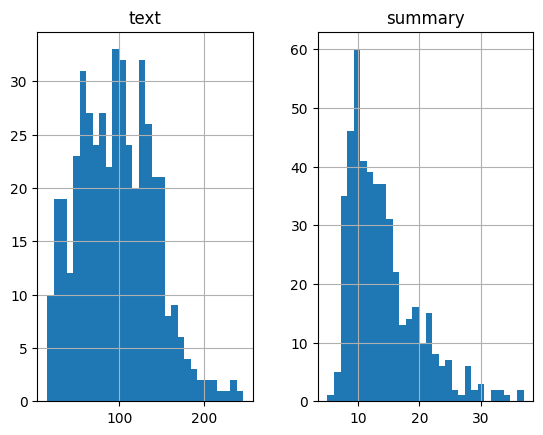

In [ ]:
# Calculate the word count for each paragraph and reference summary
text_word_count = []  # List to store word count for each paragraph
summary_word_count = []  # List to store word count for each summary

# Count words in each paragraph and summary
for i in df['paragraphs']:
    text_word_count.append(len(i.split()))  # Count words in each paragraph

for i in df['reference_summary']:
    summary_word_count.append(len(i.split()))  # Count words in each summary

# Create a DataFrame to store word counts for both text and summaries
length_df = pd.DataFrame({'text': text_word_count, 'summary': summary_word_count})

# Plot the distribution of word lengths for both columns
length_df.hist(bins=30)  # Create histogram with 30 bins
plt.show()  # Display the plot


In [ ]:
# Function to compute the 75th percentile (quantile) for text and summary lengths
def quantile_3(text_word_count, summary_word_count):
    # Return the 75th percentile for both text and summary word counts
    return int(np.quantile(text_word_count, 0.75)), int(np.quantile(summary_word_count, 0.75))

# Get the maximum length for paragraphs and summaries based on the 75th percentile
max_length_paragraphs, max_length_summary = quantile_3(text_word_count, summary_word_count)


In [ ]:
print(f"Max length paragraphs: {max_length_paragraphs}")
print(f"Max length summary: {max_length_summary}")

Max length paragraphs: 128
Max length summary: 16


In [ ]:
# Function to create a word-to-index mapping for two columns in the dataset
def word2index(data, column1, column2):
    # Initialize list with special tokens
    unique_words = ['_PAD_', '_START_', '_END_']

    # Add unique words from the first column to the list
    for text in data[column1]:
        for word in text.split():
            if word not in unique_words:
                unique_words.append(word)

    # Add unique words from the second column to the list
    for text in data[column2]:
        for word in text.split():
            if word not in unique_words:
                unique_words.append(word)

    # Create a word-to-index mapping
    word2idx = {word: idx for idx, word in enumerate(unique_words)}
    return word2idx



In [ ]:
# Create the word-to-index mapping for the 'paragraphs' and 'reference_summary' columns
word2idx = word2index(df, 'paragraphs', 'reference_summary')

# Save the word-to-index mapping to a text file
with open('word2index.txt', 'w') as file:
    for key, value in word2idx.items():
        file.write(f"{key}, {value}\n")  # Write each word and its index to the file


In [ ]:
# Open and read the word-to-index mapping from the text file
word2idx = {}
with open('word2index.txt', 'r') as file:
    for line in file:
        # Split the word and index and store in the dictionary
        word2idx[line.split(',')[0]] = int(line.split(',')[1])



In [ ]:
len(word2idx)

7747

In [ ]:
print(word2idx["_PAD_"])

0


In [ ]:
# Function to create an index-to-word mapping from word-to-index mapping
def index2word(word2idx):
    # Reverse the word2idx dictionary to create idx2word mapping
    idx2word = {idx: word for word, idx in word2idx.items()}
    return idx2word

# Create the index-to-word mapping
idx2word = index2word(word2idx)


In [ ]:
print(idx2word[0])

_PAD_


In [ ]:
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf
import numpy as np

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = TFBertModel.from_pretrained('bert-base-multilingual-cased')

def get_word_embedding(word, tokenizer, model):
    # Tokenize the word
    tokens = tokenizer.tokenize(word)
    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # Add [CLS] and [SEP] manually
    input_ids = [tokenizer.cls_token_id] + input_ids + [tokenizer.sep_token_id]
    input_ids = tf.constant([input_ids])  # Add batch dimension

    # Get model output
    outputs = model(input_ids)
    hidden_states = outputs.last_hidden_state[0]  # Shape: (sequence_length, hidden_size)

    # Exclude [CLS] and [SEP] tokens
    word_hidden_states = hidden_states[1:-1]  # Ignore the first ([CLS]) and last ([SEP]) embeddings

    # Compute mean embedding for the word
    word_embedding = tf.reduce_mean(word_hidden_states, axis=0).numpy()

    return word_embedding

# Initialize word_embeddings dictionary
word_embeddings = {}

# Handle the special case for _PAD_
for word, idx in word2idx.items():
    if word == '_PAD_':
        word_embeddings[word] = np.zeros(768)  # Set embedding for _PAD_ as zero vector
    else:
        word_embeddings[word] = get_word_embedding(word, tokenizer, model)



Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
print(len(word_embeddings))

7634


In [ ]:
# Define embedding dimension and vocabulary size
embedding_dim = 768
vocab_size = len(word2idx)

# Initialize the embedding matrix with zeros
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Populate the embedding matrix with word embeddings
for word, idx in word2idx.items():
    embedding_matrix[idx] = word_embeddings[word]  # Assign the word embedding to the matrix

# Save the embedding matrix to a text file
np.savetxt('embedding_matrix.txt', embedding_matrix)


In [ ]:
# open matriks embedding in txt file
embedding_matrix = np.loadtxt('embedding_matrix.txt')

In [ ]:
# Open and read the embedding matrix file
with open('embedding_matrix.txt', 'r') as file:
    for i, line in enumerate(file):
        # Count the number of columns in each line
        num_columns = len(line.strip().split())
        # Check if the number of columns is not equal to the expected embedding dimension
        if num_columns != 768:
            print(f"Line {i + 1} has {num_columns} columns.")  # Print the line number if the column count is incorrect


In [ ]:
print(embedding_matrix[1])

[ 1.24077022e+00 -1.89099520e-01  1.82193920e-01 -1.93258747e-04
  1.24925770e-01  2.33548656e-01 -3.12327176e-01  1.45713650e-02
 -1.35530606e-02 -5.09124637e-01  3.65900964e-01  1.01433849e+00
  6.10969663e-01 -6.08987272e-01  1.18942007e-01 -3.10945064e-01
 -1.31178841e-01  3.75319541e-01 -3.34095895e-01 -4.97454852e-02
  2.67707616e-01 -5.90324104e-01 -9.15504918e-02  3.61752540e-01
 -4.41772193e-02 -1.08319104e+00  3.15817177e-01 -3.60118985e-01
 -1.89687759e-01  6.58266172e-02  6.27495050e-01  7.45512545e-01
 -2.04333156e-01  8.37857842e-01 -1.12647794e-01  3.52818638e-01
  1.99458778e-01 -2.44999751e-01 -3.48465562e-01 -1.20247269e+00
 -2.77229249e-01  5.62599182e-01  4.50970113e-01 -1.07599884e-01
  1.01420768e-01 -2.36336038e-01  2.44245514e-01 -2.28380188e-02
 -2.48654649e-01 -6.16188884e-01  1.64541945e-01 -1.56695321e-02
 -3.31713587e-01  2.54786938e-01 -1.30464986e-01  5.29773474e-01
 -2.51950860e-01 -1.07331288e+00  1.91600062e-02 -4.51408625e-01
  5.88113427e-01  3.59897

In [ ]:
print(embedding_matrix.shape)

(7747, 768)


In [ ]:
# Function to convert text to sequences of word indices
def text2sequence(data, column1, column2, word2idx, max_length_paragraphs, max_length_summary):
    # Convert paragraphs to sequences of word indices
    paragraphs = data[column1].apply(lambda x: [word2idx[word] for word in x.split()])

    # Convert reference summaries to sequences of word indices
    reference_summary = data[column2].apply(lambda x: [word2idx[word] for word in x.split()])

    # Pad sequences to ensure uniform length
    paragraphs = pad_sequences(paragraphs, maxlen=max_length_paragraphs, padding='post', value=word2idx['_PAD_'])
    reference_summary = pad_sequences(reference_summary, maxlen=max_length_summary, padding='post', value=word2idx['_PAD_'])

    return paragraphs, reference_summary


In [ ]:
# Convert text in 'paragraphs' and 'reference_summary' columns to sequences of word indices
paragraphs, reference_summary = text2sequence(df, 'paragraphs', 'reference_summary', word2idx, max_length_paragraphs, max_length_summary)


In [ ]:
print(len(paragraphs[0]))
print(reference_summary[0])
print(paragraphs.shape)
print(reference_summary.shape)

128
[   1    5    6    7   21   11   12   24   25  119 6823 2060   47    2
    0    0]
(464, 128)
(464, 16)


### Spliting Data

In [ ]:

# Split 85% training dan 15% temporary (validation + testing)
x_tr, x_temp, y_tr, y_temp = train_test_split(
    paragraphs, reference_summary, test_size=0.15, random_state=42)  # 70% train, 30% temp

# Split temporary menjadi 10% validation dan 5% testing
x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=0.33, random_state=42)  # 20% val, 10% test

In [ ]:
print(x_tr.shape)
print(x_val.shape)
print(x_test.shape)
print(y_tr.shape)
print(y_val.shape)
print(y_test.shape)

(394, 128)
(46, 128)
(24, 128)
(394, 16)
(46, 16)
(24, 16)


In [ ]:
print(x_tr.dtype, y_tr.dtype,)
print(x_val.dtype, y_val.dtype)
print(x_test.dtype, y_test.dtype)

int32 int32
int32 int32
int32 int32


In [ ]:
print(x_tr[0])
print(y_tr[0])

[  56   30  682 1886   34  751 1747   20 5218   49 1043 1743  139    7
 1750 5219   58   59  116  758 5220 1141   44  613  805   86   20 4160
  139    7 1146 5221  224  412 1068  369   46  909  186 5222  995 5026
 5223  226   27 5224  119   65 4402 1043 1743  419  772  755 1750 5225
  441 3707 3157 1017  525    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
[6982 1757 2394 1043 1743 7050 7566 1141  986 7431 7269 2119 7056  557
 1704    2]


### Building And Training Model

In [ ]:
# Define vocabulary size, embedding dimension, and maximum lengths for paragraphs and summaries
vocab_size = len(word2idx)  # Number of unique words in the word2idx mapping
embedding_dim = 768  # Dimensionality of the word embeddings
max_length_paragraphs = max_length_paragraphs  # Maximum length for paragraphs
max_length_summary = max_length_summary  # Maximum length for summaries
embedding_matrix = embedding_matrix  # Predefined embedding matrix


In [ ]:

logger = tf.get_logger()

class AttentionLayer(tf.keras.layers.Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs

        logger.debug(f"encoder_out_seq.shape = {encoder_out_seq.shape}")
        logger.debug(f"decoder_out_seq.shape = {decoder_out_seq.shape}")

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            logger.debug("Running energy computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_full_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim

            logger.debug(f"U_a_dot_h.shape = {U_a_dot_h.shape}")

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)

            logger.debug(f"Ws_plus_Uh.shape = {Ws_plus_Uh.shape}")

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            logger.debug(f"ei.shape = {e_i.shape}")

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            logger.debug("Running attention vector computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_full_seq * K.expand_dims(inputs, -1), axis=1)

            logger.debug(f"ci.shape = {c_i.shape}")

            return c_i, [c_i]

        # we don't maintain states between steps when computing attention
        # attention is stateless, so we're passing a fake state for RNN step function
        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e], constants=[encoder_out_seq]
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c], constants=[encoder_out_seq]
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]


In [ ]:

# Building Model Bidirectional LSTM
latent_dim = 256
# Encoder
encoder_inputs = Input(shape=(max_length_paragraphs,), dtype='int32', name='encoder_inputs')
encoder_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], trainable=False)(encoder_inputs)

# Bidirectional LSTM
encoder_lstm1 = Bidirectional(LSTM(latent_dim, return_state=True, return_sequences=True,))
encoder_outputs, forward_state_h, forward_state_c, backward_state_h, backward_state_c = encoder_lstm1(encoder_embedding)

# Combine forward and backward states
state_h = Concatenate()([forward_state_h, backward_state_h])  # Combined hidden state
state_c = Concatenate()([forward_state_c, backward_state_c])  # Combined cell state

# Decoder
decoder_inputs = Input(shape=(None,), dtype='int32', name='decoder_inputs')
decoder_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], trainable=False)(decoder_inputs)

# Decoder LSTM
decoder_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=[state_h, state_c])

# Attention Layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concatenate Attention output and Decoder output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# Dense Layer
decoder_dense = TimeDistributed(Dense(vocab_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Model Definition
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Model Summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs            │ (None, 128)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 128, 768)       │      5,949,696 │ encoder_inputs[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_inputs            │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ [(None, 128, 512),     │      2,099,200 │ embedding[0][0]        │
│ (Bidirectional)           │ (None, 256), (None,    │                │                        │
│                           │ 256), (None, 256),     │                │                        │
│                           │ (None, 256)]           │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, None, 768)      │      5,949,696 │ decoder_inputs[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 512)            │              0 │ bidirectional[0][1],   │
│                           │                        │                │ bidirectional[0][3]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 512)            │              0 │ bidirectional[0][2],   │
│ (Concatenate)             │                        │                │ bidirectional[0][4]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, None, 512),    │      2,623,488 │ embedding_1[0][0],     │
│                           │ (None, 512), (None,    │                │ concatenate[0][0],     │
│                           │ 512)]                  │                │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_layer           │ [(None, None, 512),    │        524,800 │ bidirectional[0][0],   │
│ (AttentionLayer)          │ (None, None, 128)]     │                │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concat_layer              │ (None, None, 1024)     │              0 │ lstm_1[0][0],          │
│ (Concatenate)             │                        │                │ attention_layer[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed          │ (None, None, 7747)     │      7,940,675 │ concat_layer[0][0]     │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 25,087,555 (95.70 MB)

 Trainable params: 13,188,163 (50.31 MB)

 Non-trainable params: 11,899,392 (45.39 MB)

In [ ]:
# Define the Adam optimizer with a learning rate of 0.0001
optimizer = Adam(learning_rate=0.0001)

# Compile the model with the optimizer, sparse categorical cross-entropy loss, and accuracy metric
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])



In [ ]:
# Define the EarlyStopping callback to monitor validation loss
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,          # Stop after 5 epochs of no improvement
                               restore_best_weights=True,  # Restore the best weights when stopping
                               mode='min',          # Stop when the validation loss is minimized
                               min_delta=0.0001)    # Minimum change to qualify as an improvement


In [ ]:
# Train the model using the training and validation data
history = model.fit(
    [x_tr, y_tr[:, :-1]],  # Input for the encoder and shifted decoder input
    y_tr[:, 1:],           # Target output for the decoder (shifted target)
    validation_data=([x_val, y_val[:, :-1]], y_val[:, 1:]),  # Validation data (shifted for both input and target)
    batch_size=256,        # Batch size for training
    callbacks=[early_stopping],  # Use early stopping callback
    epochs=100             # Maximum number of epochs to train
)



Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.0244 - loss: 8.9271 - val_accuracy: 0.2507 - val_loss: 8.7992
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 438ms/step - accuracy: 0.2257 - loss: 8.7862 - val_accuracy: 0.2507 - val_loss: 8.6478
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.2261 - loss: 8.6342 - val_accuracy: 0.2507 - val_loss: 8.4795
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 474ms/step - accuracy: 0.2270 - loss: 8.4627 - val_accuracy: 0.2507 - val_loss: 8.2886
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 428ms/step - accuracy: 0.2241 - loss: 8.2723 - val_accuracy: 0.2507 - val_loss: 8.0716
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 426ms/step - accuracy: 0.2261 - loss: 8.0475 - val_accuracy: 0.2507 - val_loss: 7.8298
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 428ms/step - accuracy: 0.2259 - loss: 7.7978 - val_accuracy: 0.2507 - val_loss: 7.5695
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 428ms/step - accuracy: 0.2264 - loss: 7.5230 - val_accuracy: 0.2507 - val

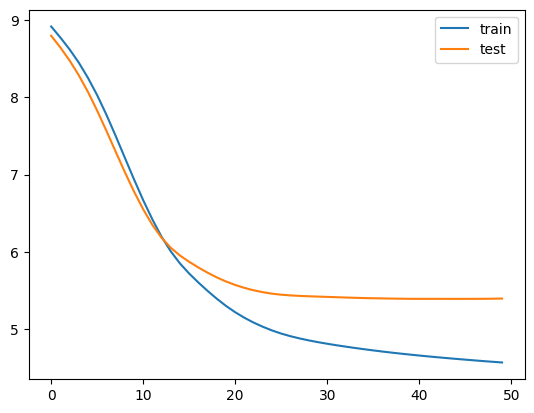

In [ ]:
# Plot the training and validation loss over epochs
plt.plot(history.history['loss'], label='train')  # Plot training loss
plt.plot(history.history['val_loss'], label='test')  # Plot validation loss
plt.legend()  # Show legend to differentiate the lines
plt.show()  # Display the plot


### Evaluation

In [ ]:
# Inference Decoder Encoder

# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
# Decoder Inference
decoder_state_input_h = Input(shape=(latent_dim * 2,))
decoder_state_input_c = Input(shape=(latent_dim * 2,))
decoder_hidden_state_input = Input(shape=(max_length_paragraphs, latent_dim * 2))

# Get the embeddings of the decoder sequence
dec_emb2 = decoder_embedding

# Decoder LSTM
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# Attention Layer
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])

# Concatenate attention output and decoder output
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# Output layer for generating vocab probabilities
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final Decoder Model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2]
)


In [ ]:
# Function to decode the input sequence and generate a summary
def decode_sequence(input_seq):
    # Predict the initial encoder output
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Initialize the target sequence with the _START_ token
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx['_START_']

    stop_condition = False
    decoded_sentence = ''

    # Generate tokens until the stop condition is met
    while not stop_condition:
        # Predict the next token in the sequence
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Get the index of the predicted token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])

        # Skip padding token
        if sampled_token_index == word2idx['_PAD_']:
            continue

        # Get the actual word corresponding to the token
        sampled_token = idx2word.get(sampled_token_index, '<UNK>')

        # Add the token to the decoded sentence if it's not the _END_ token
        if sampled_token != '_END_':
            decoded_sentence += ' ' + sampled_token

        # Stop when the _END_ token is reached or sentence length exceeds max length
        if sampled_token == '_END_' or len(decoded_sentence.split()) >= max_length_summary - 1:
            stop_condition = True

        # Update the target sequence for the next iteration
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
        e_h, e_c = h, c

    return decoded_sentence


In [ ]:
import heapq

def decode_sequence_with_beam_search(input_seq, beam_width=5):
    # Step 1: Encode the input sequence
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Step 2: Initialize beam search variables
    start_token_index = word2idx['_START_']
    end_token_index = word2idx['_END_']
    max_decoding_steps = max_length_summary - 1

    # Priority queue to hold beams, sorted by score
    beams = [(0, [start_token_index], e_h, e_c)]  # (negative log prob, sequence, hidden state, cell state)

    # Step 3: Start beam search
    results = []  # Completed beams

    while beams:
        # Process each beam
        new_beams = []

        for log_prob, sequence, h, c in beams:
            # Get the last token
            last_token_index = sequence[-1]

            # Stop if the beam ends with the end token or exceeds max decoding steps
            if last_token_index == end_token_index or len(sequence) >= max_decoding_steps:
                results.append((log_prob, sequence))
                continue

            # Prepare input for the decoder
            target_seq = np.zeros((1, 1))
            target_seq[0, 0] = last_token_index

            # Predict next tokens
            output_tokens, new_h, new_c = decoder_model.predict([target_seq] + [e_out, h, c])

            # Get top beam_width tokens and their probabilities
            top_k_indices = np.argsort(output_tokens[0, -1, :])[-beam_width:]  # Top k tokens
            for idx in top_k_indices:
                new_log_prob = log_prob - np.log(output_tokens[0, -1, idx] + 1e-10)  # Accumulate negative log prob
                new_sequence = sequence + [idx]
                new_beams.append((new_log_prob, new_sequence, new_h, new_c))

        # Sort new beams by score and keep the top beam_width beams
        beams = heapq.nsmallest(beam_width, new_beams, key=lambda x: x[0])

        # Stop if all beams are completed
        if len(results) >= beam_width:
            break

    # Step 4: Choose the best sequence
    best_sequence = min(results, key=lambda x: x[0])[1]  # Sequence with the lowest negative log prob

    # Convert indices to words and remove special tokens
    decoded_sentence = ' '.join([idx2word.get(idx, '<UNK>') for idx in best_sequence if idx != start_token_index and idx != end_token_index])

    return decoded_sentence


In [ ]:
# Function to convert sequence of word indices to a summary (string)
def seq2summary(input_seq):
    newString = ''
    # Loop through the input sequence and append corresponding words to newString
    for i in input_seq:
        if ((i != 0 and i != word2idx['_START_']) and i != word2idx['_END_']):
            newString = newString + idx2word[i] + ' '  # Skip padding and special tokens
    return newString

# Function to convert sequence of word indices to text (string)
def seq2text(input_seq):
    newString = ''
    # Loop through the input sequence and append corresponding words to newString
    for i in input_seq:
        if i != 0:  # Skip padding token (0)
            newString = newString + idx2word[i] + ' '
    return newString



In [ ]:
# Example decode test data with beam search
for i in range(5):
    print("paragraphs", seq2text(x_test[i]))
    print("Original summary:", seq2summary(y_test[i]))
    print("Predicted summary:", decode_sequence_with_beam_search(x_test[i].reshape(1, max_length_paragraphs)))

paragraphs mangalèr dados cêlak kalihan wanci pangkatipun sang maharsi bisma wau prabu yudhisthira dhawuh mirantos saupakartining ambasmi kunarpanipun atmajaning gangga saparipurnaning anggènipun tatatata arakarakan agêng ingkang badhe miwaha pambêsmining layon lajêng bidhal sawarnining sajèn ugi sampun kasadhiyanan rawuhipun prabu yudhisthira sang bisma sampun karêrompa wiyasa naradha dhewala tuwin asita sarta narendra sisaning sami sirna palagan yudhisthira amarêpêki sang senapati ingkang wontên sanginggiling jêmparing lajêng anyungkêmi pada sarwi matur bilih sampun ambêkta sadaya ingkang badhe amiwaha tindakipun sang bisma ambuka paningalipun lajêng anganthuki dhatêng prabu yudhisthira sêmu sakalangkung sih sarta lajêng ngandika samêngko wus têkan wancine sasampunipun ngandika makatên sang bisma lajêng anolèh prabu drêtarastra dhawuh supados trêsnaa dhatêng sutanipun pandhu sarta sampun kalajênglajêng anggènipun mrihatosakên sirnaning putra amargi pandhawa tamtu sêtya tuhu anggènipu

In [ ]:
# Example decode test data with greedy search
for i in range(5):
    print("paragraphs", seq2text(x_test[i]))
    print("Original summary:", seq2summary(y_test[i]))
    print("Predicted summary:", decode_sequence(x_test[i].reshape(1, max_length_paragraphs)))

paragraphs mangalèr dados cêlak kalihan wanci pangkatipun sang maharsi bisma wau prabu yudhisthira dhawuh mirantos saupakartining ambasmi kunarpanipun atmajaning gangga saparipurnaning anggènipun tatatata arakarakan agêng ingkang badhe miwaha pambêsmining layon lajêng bidhal sawarnining sajèn ugi sampun kasadhiyanan rawuhipun prabu yudhisthira sang bisma sampun karêrompa wiyasa naradha dhewala tuwin asita sarta narendra sisaning sami sirna palagan yudhisthira amarêpêki sang senapati ingkang wontên sanginggiling jêmparing lajêng anyungkêmi pada sarwi matur bilih sampun ambêkta sadaya ingkang badhe amiwaha tindakipun sang bisma ambuka paningalipun lajêng anganthuki dhatêng prabu yudhisthira sêmu sakalangkung sih sarta lajêng ngandika samêngko wus têkan wancine sasampunipun ngandika makatên sang bisma lajêng anolèh prabu drêtarastra dhawuh supados trêsnaa dhatêng sutanipun pandhu sarta sampun kalajênglajêng anggènipun mrihatosakên sirnaning putra amargi pandhawa tamtu sêtya tuhu anggènipu

In [ ]:
# Install and import the Rouge Score library
!pip install rouge_score
from rouge_score import rouge_scorer

# Function to calculate ROUGE-1, ROUGE-2, and ROUGE-L scores
def calculate_rouge(predictions, references):
    """
    Menghitung metrik ROUGE-1, ROUGE-2, dan ROUGE-L
    predictions: list of generated summaries (output dari model)
    references: list of reference summaries (ground truth summaries)
    """
    # Initialize RougeScorer with ROUGE-1, ROUGE-2, and ROUGE-L metrics
    scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)

    rouge_1_scores = []
    rouge_2_scores = []
    rouge_L_scores = []

    # Iterate through predictions and references, calculate ROUGE scores
    for prediction, reference in zip(predictions, references):
        scores = scorer.score(reference, prediction)
        rouge_1_scores.append(scores["rouge1"].fmeasure)
        rouge_2_scores.append(scores["rouge2"].fmeasure)
        rouge_L_scores.append(scores["rougeL"].fmeasure)

    # Return average ROUGE scores
    avg_rouge_1 = sum(rouge_1_scores) / len(rouge_1_scores)
    avg_rouge_2 = sum(rouge_2_scores) / len(rouge_2_scores)
    avg_rouge_L = sum(rouge_L_scores) / len(rouge_L_scores)

    return avg_rouge_1, avg_rouge_2, avg_rouge_L


# Prepare predictions and references for evaluation
predictions = []
references = []

for i in range(len(x_test)):  # Loop through all test data
    # Decode target reference (convert indices to words, excluding padding and special tokens)
    reference = ' '.join([idx2word[idx] for idx in y_test[i] if idx not in [0, 1, 2]])
    references.append(reference)

    # Generate prediction using the decoder (greedy search)
    prediction = decode_sequence(x_test[i:i+1])  # The decoder output is a string
    predictions.append(prediction)

# Calculate Gready ROUGE scores
g_rouge_1, g_rouge_2, g_rouge_L = calculate_rouge(predictions, references)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━

In [ ]:
# Install and import the Rouge Score library
!pip install rouge_score
from rouge_score import rouge_scorer

# Function to calculate ROUGE-1, ROUGE-2, and ROUGE-L scores
def calculate_rouge(predictions, references):
    """
    Menghitung metrik ROUGE-1, ROUGE-2, dan ROUGE-L
    predictions: list of generated summaries (output dari model)
    references: list of reference summaries (ground truth summaries)
    """
    # Initialize RougeScorer with ROUGE-1, ROUGE-2, and ROUGE-L metrics
    scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)

    rouge_1_scores = []
    rouge_2_scores = []
    rouge_L_scores = []

    # Calculate ROUGE scores for each pair of prediction and reference
    for prediction, reference in zip(predictions, references):
        scores = scorer.score(reference, prediction)
        rouge_1_scores.append(scores["rouge1"].fmeasure)
        rouge_2_scores.append(scores["rouge2"].fmeasure)
        rouge_L_scores.append(scores["rougeL"].fmeasure)

    # Calculate average ROUGE scores
    avg_rouge_1 = sum(rouge_1_scores) / len(rouge_1_scores)
    avg_rouge_2 = sum(rouge_2_scores) / len(rouge_2_scores)
    avg_rouge_L = sum(rouge_L_scores) / len(rouge_L_scores)

    return avg_rouge_1, avg_rouge_2, avg_rouge_L


# Prepare predictions and references for evaluation
predictions = []
references = []

# Iterate through test data to generate predictions and collect references
for i in range(len(x_test)):  # Loop through all test data
    # Decode the reference (converting indices to words, excluding padding and special tokens)
    reference = ' '.join([idx2word[idx] for idx in y_test[i] if idx not in [0, 1, 2]])
    references.append(reference)

    # Generate prediction using beam search instead of greedy decoding
    prediction = decode_sequence_with_beam_search(x_test[i:i+1])  # Decodes using beam search and returns a string
    predictions.append(prediction)

# Calculate Beam ROUGE scores based on the generated predictions and reference summaries
b_rouge_1, b_rouge_2, b_rouge_L = calculate_rouge(predictions, references)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

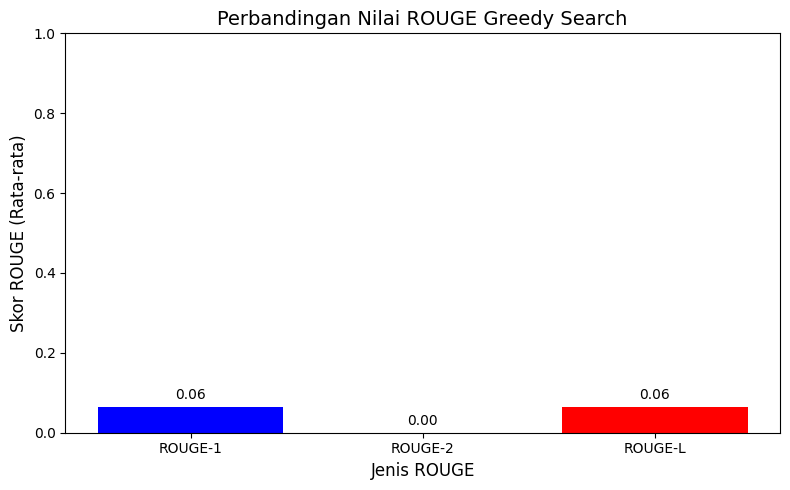

In [ ]:
# ROUGE scores data
rouge_scores = [g_rouge_1, g_rouge_2, g_rouge_L]  # Storing calculated ROUGE scores
rouge_labels = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']  # Labels for ROUGE metrics

# Create a bar chart
plt.figure(figsize=(8, 5))  # Set the figure size
plt.bar(rouge_labels, rouge_scores, color=['blue', 'green', 'red'])  # Create a bar chart with different colors

# Add title and labels
plt.title('Comparison of ROUGE Scores (Greedy Search)', fontsize=14)  # Title of the chart
plt.ylabel('Average ROUGE Score', fontsize=12)  # Y-axis label
plt.xlabel('ROUGE Type', fontsize=12)  # X-axis label
plt.ylim(0, 1)  # ROUGE scores range from 0 to 1, set the y-axis limits accordingly

# Add numerical values above the bars
for i, score in enumerate(rouge_scores):
    plt.text(i, score + 0.02, f"{score:.2f}", ha='center', fontsize=10)  # Display score above each bar

# Save the plot to a PNG file
plt.savefig('Rouge_Greedy.png', dpi=300)  # Save the plot with high resolution (dpi=300)

# Show the plot
plt.tight_layout()  # Adjust the layout to prevent overlap
plt.show()  # Display the plot


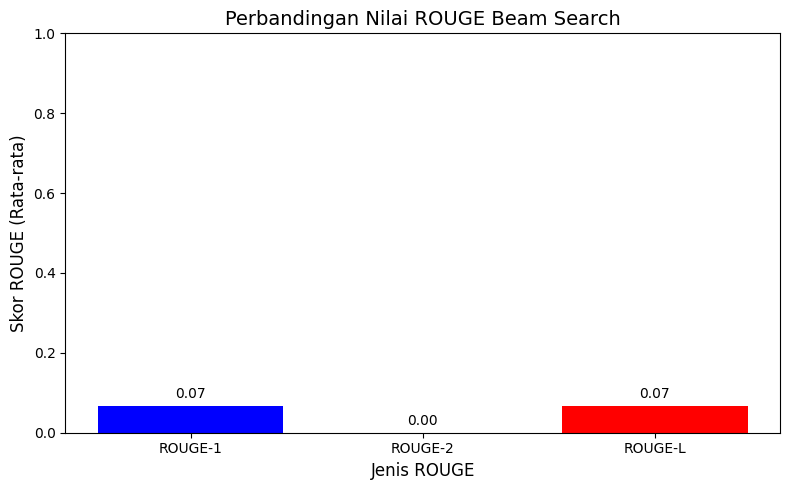

In [ ]:
# ROUGE scores data
rouge_scores = [b_rouge_1, b_rouge_2, b_rouge_L]  # Storing the ROUGE scores for Beam Search
rouge_labels = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']  # Labels for ROUGE metrics

# Create a bar chart
plt.figure(figsize=(8, 5))  # Set the figure size
plt.bar(rouge_labels, rouge_scores, color=['blue', 'green', 'red'])  # Create a bar chart with different colors for each ROUGE score

# Add title and labels
plt.title('Comparison of ROUGE Scores (Beam Search)', fontsize=14)  # Title of the chart
plt.ylabel('Average ROUGE Score', fontsize=12)  # Y-axis label
plt.xlabel('ROUGE Type', fontsize=12)  # X-axis label
plt.ylim(0, 1)  # ROUGE scores range from 0 to 1, so set the y-axis limits between 0 and 1

# Add numerical values above the bars
for i, score in enumerate(rouge_scores):
    plt.text(i, score + 0.02, f"{score:.2f}", ha='center', fontsize=10)  # Display the ROUGE score above each bar

# Save the plot to a PNG file
plt.savefig('Rouge_Beam.png', dpi=300)  # Save the plot with high resolution (dpi=300)

# Display the plot
plt.tight_layout()  # Adjust the layout to prevent overlapping elements
plt.show()  # Show the plot


In [ ]:
# Save the entire model to a file
model.save("Eksp1g.h5")  # Save the model in HDF5 format, which includes both the architecture and weights

# Save the model's weights separately
model.save_weights("Eksp1g.weights.h5")  # Save only the model's weights to a separate file

